In [55]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import scipy

In [2]:
from openpilot.transformations import get_calib_from_vp, FOCAL_LENGTH, FRAME_SIZE

In [77]:
import generate_labels
from helpers import const, images
from helpers.lines import get_intersection
importlib.reload(const)
importlib.reload(images)
importlib.reload(generate_labels)
STANDARD_LEFT_LANE = const.STANDARD_LEFT_LANE
STANDARD_RIGHT_LANE = const.STANDARD_RIGHT_LANE
generate_and_write_labels = generate_labels.generate_and_write_labels
image_to_vp = generate_labels.image_to_vp

In [4]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: [(frame, calibration), ...]
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

In [79]:
# Running this block overwrites the generated eval (/eval) labels

vid_0 = ('eval/0.txt', training_data[:1200])
vid_1 = ('eval/1.txt', training_data[1200:2400])
vid_2 = ('eval/2.txt', training_data[2400:3600])
vid_3 = ('eval/3.txt', training_data[3600:4800])
vid_4 = ('eval/4.txt', training_data[4800:])
eval_videos = [vid_0, vid_1, vid_2, vid_3, vid_4]

for eval_video in eval_videos:
    filename, frames = eval_video
    generate_and_write_labels(filename, frames)

In [9]:
# Running this block overwrites the generated test (/test) labels

vid_5 = ('unlabeled/5.txt', test_data[:1200])
vid_6 = ('unlabeled/6.txt', test_data[1200:2400])
vid_7 = ('unlabeled/7.txt', test_data[2400:3600])
vid_8 = ('unlabeled/8.txt', test_data[3600:4800])
vid_9 = ('unlabeled/9.txt', test_data[4800:])
test_videos = [vid_5, vid_6, vid_7, vid_8, vid_9]

for test_video in test_videos:
    filename, frames = test_video
    generate_and_write_labels(filename, frames)

In [80]:
# Load in the generated eval labels

eval_labels_0 = pd.read_csv('eval/0.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
eval_labels_1 = pd.read_csv('eval/1.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
eval_labels_2 = pd.read_csv('eval/2.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
eval_labels_3 = pd.read_csv('eval/3.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
eval_labels_4 = pd.read_csv('eval/4.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
eval_videos = [eval_labels_0, eval_labels_1, eval_labels_2, eval_labels_3, eval_labels_4]

eval_labels = pd.concat(eval_videos, ignore_index=True)

In [81]:
# Load in the generated test labels

train_labels_0 = pd.read_csv('labeled/0.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_1 = pd.read_csv('labeled/1.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_2 = pd.read_csv('labeled/2.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_3 = pd.read_csv('labeled/3.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_4 = pd.read_csv('labeled/4.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_frames = [train_labels_0, train_labels_1, train_labels_2, train_labels_3, train_labels_4]

train_labels = pd.concat(train_frames, ignore_index=True)

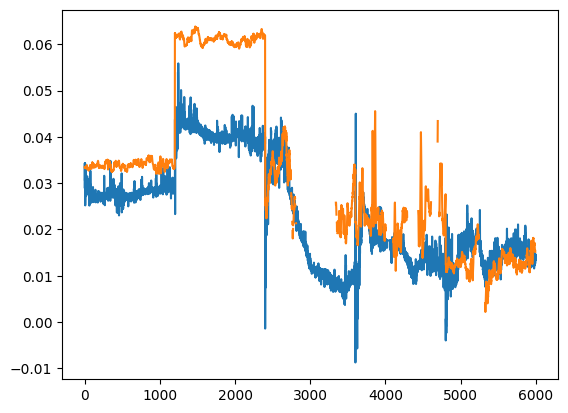

In [82]:
# training / eval pitch comparison

train_pitch_labels = [x for x in train_labels['pitch']]
eval_pitch_labels = [x for x in eval_labels['pitch']]

plt.plot(range(5996), eval_pitch_labels, label='pitch-eval')
plt.plot(range(5996), train_pitch_labels, label='pitch-train')

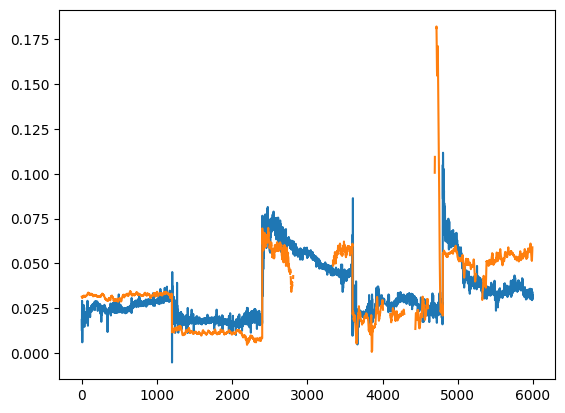

In [83]:
# training / eval yaw comparison

train_yaw_labels = [x for x in train_labels['yaw']]
eval_yaw_labels = [x for x in eval_labels['yaw']]

plt.plot(range(5996), eval_yaw_labels, label='yaw-eval')
plt.plot(range(5996), train_yaw_labels, label='yaw-train')

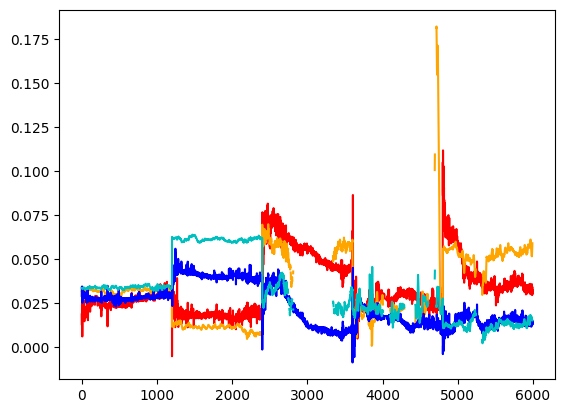

In [14]:
x = range(5996)
plt.plot(x, eval_yaw_labels, label='yaw-eval', color='red')
plt.plot(x, train_yaw_labels, label='yaw-train', color='orange')

plt.plot(x, eval_pitch_labels, label='pitch-eval', color='b')
plt.plot(x, train_pitch_labels, label='pitch-train', color='c')

In [27]:
test_labels_0 = pd.read_csv('unlabeled/5.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_1 = pd.read_csv('unlabeled/6.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_2 = pd.read_csv('unlabeled/7.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_3 = pd.read_csv('unlabeled/8.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_4 = pd.read_csv('unlabeled/9.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_videos = [test_labels_0, test_labels_1, test_labels_2, test_labels_3, test_labels_4]

test_labels = pd.concat(test_videos, ignore_index=True)

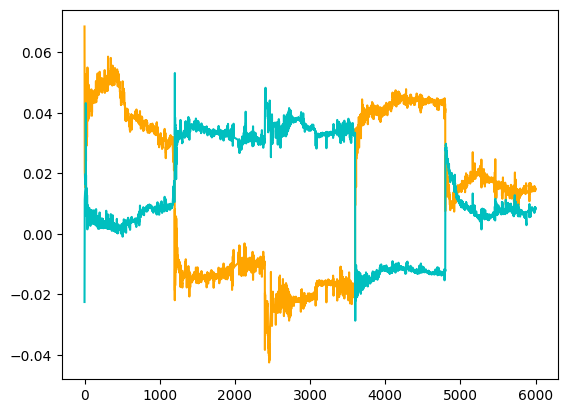

In [16]:
# Sense checking the test labels

plt.plot(test_labels.index, test_labels['yaw'], label='yaw-test', color='orange')
plt.plot(test_labels.index, test_labels['pitch'], label='pitch-test', color='c')

The above test labels seem reasonable. There are jumps between videos and significantly less variation within videos, which is expected. The eval.py yielded 13.5% MSE on the labeled data using the same calibration logic. Given that this is roughly half the 25% MSE limit and the logic should generalize well, I'm comfortable submitting these labels.

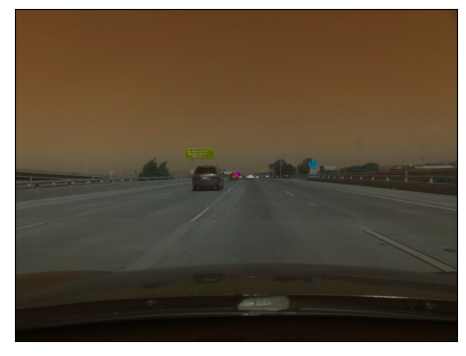

In [75]:
# Edited standard lines to roughly match perfect camera mounting

intersection = get_intersection(STANDARD_LEFT_LANE, STANDARD_RIGHT_LANE) 
test_vp = np.array([int(FRAME_SIZE[0]/2), int(FRAME_SIZE[1]/2)]) # center of the image

im_copy = np.copy(test_data[100])
cv2.circle(im_copy, (int(intersection[0]), int(intersection[1])), 5, (0, 0, 255), -1) # standard lanes vp
cv2.circle(im_copy, (int(test_vp[0]), int(test_vp[1])), 5, (255, 0, 0), -1) # center of image
images.show([im_copy])

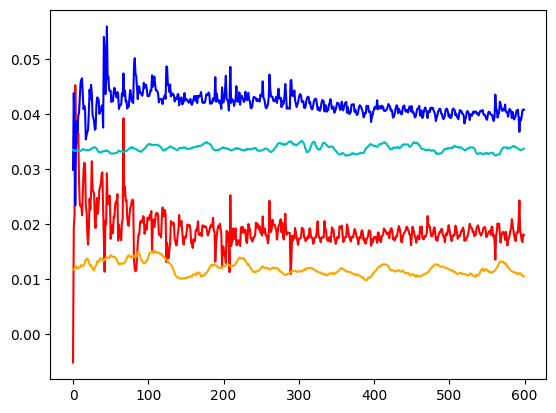

In [78]:
# Sandbox for testing variations on portions of the data

calculated_vps = []
left_lanes = []
right_lanes = []
scale = []

count = 600
start_idx = 1200
training_slice = training_data[start_idx:count+start_idx]
for frame in training_slice:
    current_img = np.copy(frame)
    vp = image_to_vp(current_img, left_lanes, right_lanes)
    _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
    calculated_vps.append([pitch_calib, yaw_calib])

train_yaw_labels = [x for x in train_labels['yaw'][start_idx:count+start_idx]]
test_yaw_labels = [yaw for pitch, yaw in calculated_vps]

train_pitch_labels = [x for x in train_labels['pitch'][:count]]
test_pitch_labels = [pitch for pitch, yaw in calculated_vps]


plt.plot(range(count), test_yaw_labels, label='yaw-test', color='red')
plt.plot(range(count), train_yaw_labels, label='yaw-train', color='orange')
plt.plot(range(count), test_pitch_labels, label='pitch-test', color='b')
plt.plot(range(count), train_pitch_labels, label='pitch-train', color='c')